In [1]:
# =============================================================================
# THREE-STAGE DINOV3 FINE-TUNING SCRIPT
# =============================================================================
# This script is designed to be run in a notebook-like environment (e.g., Jupyter, VSCode)
# where each major section (marked as "CELL") is executed sequentially.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from transformers import AutoModel
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import os
import time

# =============================================================================
# CELL 0: SHARED CONFIGURATION AND SETUP
# =============================================================================

# --- Main Configuration for All Stages (Updated as per your request) ---
config = {
    # CORRECTED: Point this to the main folder containing your class subdirectories (e.g., Alarippu, Jathiswaram)
    'base_dir': r'images',
    'model_name': 'facebook/dinov3-convnext-tiny-pretrain-lvd1689m',
    'img_size': 224,
    'num_workers': 0,

    # Stage 1: Head Training
    'stage1_save_path': r'stage1_head_trained.pth',
    'stage1_epochs': 15,
    'stage1_lr': 1e-3,
    'stage1_batch_size': 32,

    # Stage 2: Full Network Training
    'stage2_load_path': r'stage1_head_trained.pth',
    'stage2_save_path': r'stage2_full_trained.pth',
    'stage2_epochs': 30,
    'stage2_lr': 1e-4,
    'stage2_batch_size': 16,
    'stage2_patience': 7,

    # Stage 3: Fine-tuning
    'stage3_load_path': r'stage2_full_trained.pth',
    'stage3_save_path': r'best_finetuned_model.pth', # Final model
    'stage3_epochs': 25,
    'stage3_lr': 1e-5,
    'stage3_batch_size': 16,
    'stage3_patience': 5,
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Shared Functions ---

# CORRECTED: This function now automatically splits your data
def get_data_loaders(base_dir, img_size, batch_size, num_workers):
    """
    Loads images from a single directory and automatically splits them into
    training, validation, and test sets.
    """
    # Define separate transforms for training (with augmentation) and validation/testing
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # To apply different transforms, we create two dataset instances from the same folder
    # This is a standard and effective way to handle this in PyTorch.
    dataset_for_training = datasets.ImageFolder(root=base_dir, transform=train_transform)
    dataset_for_eval = datasets.ImageFolder(root=base_dir, transform=val_test_transform)

    # Define split sizes (e.g., 70% train, 15% validation, 15% test)
    total_size = len(dataset_for_training)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    print(f"Splitting {total_size} total images into: {train_size} Train, {val_size} Val, {test_size} Test")

    # Split the indices of the dataset
    indices = list(range(total_size))
    # It's good practice to shuffle before splitting
    import random
    random.seed(42) # for reproducibility
    random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size :]

    # Create Subset objects with the correct underlying dataset (and thus transform)
    train_dataset = Subset(dataset_for_training, train_indices)
    val_dataset = Subset(dataset_for_eval, val_indices)
    test_dataset = Subset(dataset_for_eval, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    num_classes = len(dataset_for_training.classes)
    class_names = dataset_for_training.classes

    return train_loader, val_loader, test_loader, num_classes, class_names


class TransformersClassifier(nn.Module):
    """Wrapper for Hugging Face models with a custom classification head."""
    def __init__(self, model_name, num_classes, drop_rate=0.1):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        feature_dim = self.backbone.config.hidden_sizes[-1]
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512), nn.BatchNorm1d(512),
            nn.GELU(), nn.Dropout(drop_rate), nn.Linear(512, num_classes)
        )
    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        features = torch.mean(outputs.last_hidden_state, dim=1)
        return self.classifier(features)

def train_one_epoch(model, loader, optimizer, criterion, device, desc=""):
    """Generic training loop for one epoch."""
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(loader, desc=f"Training ({desc})"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device, desc=""):
    """Generic validation loop."""
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc=f"Validating ({desc})"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), accuracy


Using device: cuda


In [2]:

# =============================================================================
# CELL 1: STAGE 1 - HEAD TRAINING
# =============================================================================
print("\n" + "="*80)
print("### EXECUTING CELL 1: STAGE 1 - HEAD TRAINING ###".center(80))
print("="*80)

# 1. Load Data for Stage 1
train_loader_s1, val_loader_s1, _, num_classes_s1, _ = get_data_loaders(
    config['base_dir'], config['img_size'], config['stage1_batch_size'], config['num_workers']
)

# 2. Initialize Model and Freeze Backbone
model_s1 = TransformersClassifier(config['model_name'], num_classes_s1).to(device)
print("Freezing backbone layers for head training...")
for param in model_s1.backbone.parameters():
    param.requires_grad = False

# 3. Setup Optimizer and Criterion
optimizer_s1 = optim.AdamW(model_s1.classifier.parameters(), lr=config['stage1_lr'])
criterion_s1 = nn.CrossEntropyLoss()

# 4. Training Loop
best_val_accuracy_s1 = 0.0
for epoch in range(config['stage1_epochs']):
    print(f"\n--- Stage 1, Epoch {epoch+1}/{config['stage1_epochs']} ---")
    train_loss = train_one_epoch(model_s1, train_loader_s1, optimizer_s1, criterion_s1, device, desc="Head")
    val_loss, val_acc = validate(model_s1, val_loader_s1, criterion_s1, device, desc="Head")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")
    if val_acc > best_val_accuracy_s1:
        print(f"🎉 New best val acc: {val_acc:.2%}. Saving model...")
        best_val_accuracy_s1 = val_acc
        torch.save({'model_state_dict': model_s1.state_dict()}, config['stage1_save_path'])

print(f"\n✅ Stage 1 Complete. Best accuracy: {best_val_accuracy_s1:.2%}. Model saved to {config['stage1_save_path']}")



               ### EXECUTING CELL 1: STAGE 1 - HEAD TRAINING ###                
Splitting 928 total images into: 649 Train, 139 Val, 140 Test
Freezing backbone layers for head training...

--- Stage 1, Epoch 1/15 ---


Validating (Head): 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]


Train Loss: 2.9148 | Val Loss: 2.6669, Val Acc: 19.42%
🎉 New best val acc: 19.42%. Saving model...

--- Stage 1, Epoch 2/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Train Loss: 2.1093 | Val Loss: 2.3122, Val Acc: 30.22%
🎉 New best val acc: 30.22%. Saving model...

--- Stage 1, Epoch 3/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


Train Loss: 1.6822 | Val Loss: 2.0731, Val Acc: 35.25%
🎉 New best val acc: 35.25%. Saving model...

--- Stage 1, Epoch 4/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


Train Loss: 1.4391 | Val Loss: 2.0422, Val Acc: 34.53%

--- Stage 1, Epoch 5/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Train Loss: 1.2645 | Val Loss: 1.8182, Val Acc: 43.88%
🎉 New best val acc: 43.88%. Saving model...

--- Stage 1, Epoch 6/15 ---


Validating (Head): 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Train Loss: 1.0905 | Val Loss: 1.7449, Val Acc: 45.32%
🎉 New best val acc: 45.32%. Saving model...

--- Stage 1, Epoch 7/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


Train Loss: 1.0295 | Val Loss: 1.7656, Val Acc: 45.32%

--- Stage 1, Epoch 8/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Train Loss: 0.8922 | Val Loss: 1.7047, Val Acc: 49.64%
🎉 New best val acc: 49.64%. Saving model...

--- Stage 1, Epoch 9/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Train Loss: 0.8333 | Val Loss: 1.6530, Val Acc: 46.76%

--- Stage 1, Epoch 10/15 ---


Validating (Head): 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]


Train Loss: 0.8002 | Val Loss: 1.6885, Val Acc: 41.01%

--- Stage 1, Epoch 11/15 ---


Validating (Head): 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Train Loss: 0.6238 | Val Loss: 1.6772, Val Acc: 46.04%

--- Stage 1, Epoch 12/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.55s/it]


Train Loss: 0.6137 | Val Loss: 1.5892, Val Acc: 49.64%

--- Stage 1, Epoch 13/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.49s/it]


Train Loss: 0.6122 | Val Loss: 1.7260, Val Acc: 47.48%

--- Stage 1, Epoch 14/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]


Train Loss: 0.5690 | Val Loss: 1.8054, Val Acc: 40.29%

--- Stage 1, Epoch 15/15 ---


Validating (Head): 100%|██████████| 5/5 [00:12<00:00,  2.50s/it]

Train Loss: 0.5128 | Val Loss: 1.8006, Val Acc: 51.08%
🎉 New best val acc: 51.08%. Saving model...

✅ Stage 1 Complete. Best accuracy: 51.08%. Model saved to stage1_head_trained.pth


In [4]:
# =============================================================================
# CELL 2: STAGE 2 - FULL NETWORK TRAINING
# =============================================================================
print("\n" + "="*80)
print("### EXECUTING CELL 2: STAGE 2 - FULL NETWORK TRAINING ###".center(80))
print("="*80)

# 1. Load Data for Stage 2
train_loader_s2, val_loader_s2, _, num_classes_s2, _ = get_data_loaders(
    config['base_dir'], config['img_size'], config['stage2_batch_size'], config['num_workers']
)

# 2. Initialize Model, Load Stage 1 Weights, and Unfreeze
model_s2 = TransformersClassifier(config['model_name'], num_classes_s2).to(device)
print(f"Loading weights from Stage 1: {config['stage2_load_path']}")
checkpoint_s2 = torch.load(config['stage2_load_path'], map_location=device)
model_s2.load_state_dict(checkpoint_s2['model_state_dict'])
print("Unfreezing all layers...")
for param in model_s2.parameters():
    param.requires_grad = True

# 3. Setup Optimizer and Scheduler
optimizer_s2 = optim.AdamW(model_s2.parameters(), lr=config['stage2_lr'], weight_decay=1e-5)
# CORRECTED: Changed T_eta_min to eta_min
scheduler_s2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_s2, eta_min=1e-6, T_max=config['stage2_epochs'])
criterion_s2 = nn.CrossEntropyLoss()

# 4. Training Loop with Early Stopping
best_val_accuracy_s2 = 0.0
epochs_no_improve_s2 = 0
for epoch in range(config['stage2_epochs']):
    print(f"\n--- Stage 2, Epoch {epoch+1}/{config['stage2_epochs']} ---")
    train_loss = train_one_epoch(model_s2, train_loader_s2, optimizer_s2, criterion_s2, device, desc="Full")
    val_loss, val_acc = validate(model_s2, val_loader_s2, criterion_s2, device, desc="Full")
    scheduler_s2.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")
    if val_acc > best_val_accuracy_s2:
        print(f"🎉 New best val acc: {val_acc:.2%}. Saving model...")
        best_val_accuracy_s2 = val_acc
        torch.save({'model_state_dict': model_s2.state_dict()}, config['stage2_save_path'])
        epochs_no_improve_s2 = 0
    else:
        epochs_no_improve_s2 += 1
        if epochs_no_improve_s2 >= config['stage2_patience']:
            print(f"\nStopping early after {config['stage2_patience']} epochs with no improvement.")
            break

print(f"\n✅ Stage 2 Complete. Best accuracy: {best_val_accuracy_s2:.2%}. Model saved to {config['stage2_save_path']}")




           ### EXECUTING CELL 2: STAGE 2 - FULL NETWORK TRAINING ###            
Splitting 928 total images into: 649 Train, 139 Val, 140 Test
Loading weights from Stage 1: stage1_head_trained.pth
Unfreezing all layers...

--- Stage 2, Epoch 1/30 ---


Validating (Full): 100%|██████████| 9/9 [00:11<00:00,  1.29s/it]


Train Loss: 4.0638 | Val Loss: 6.7798, Val Acc: 6.47%
🎉 New best val acc: 6.47%. Saving model...

--- Stage 2, Epoch 2/30 ---


Validating (Full): 100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


Train Loss: 3.4395 | Val Loss: 8.0106, Val Acc: 2.88%

--- Stage 2, Epoch 3/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Train Loss: 3.2319 | Val Loss: 6.2438, Val Acc: 5.04%

--- Stage 2, Epoch 4/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.37s/it]


Train Loss: 2.9133 | Val Loss: 12.1064, Val Acc: 5.04%

--- Stage 2, Epoch 5/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.37s/it]


Train Loss: 2.4886 | Val Loss: 4.1760, Val Acc: 10.79%
🎉 New best val acc: 10.79%. Saving model...

--- Stage 2, Epoch 6/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Train Loss: 2.0655 | Val Loss: 3.7645, Val Acc: 20.86%
🎉 New best val acc: 20.86%. Saving model...

--- Stage 2, Epoch 7/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Train Loss: 1.7954 | Val Loss: 3.9713, Val Acc: 14.39%

--- Stage 2, Epoch 8/30 ---


Validating (Full): 100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


Train Loss: 1.3949 | Val Loss: 2.5186, Val Acc: 31.65%
🎉 New best val acc: 31.65%. Saving model...

--- Stage 2, Epoch 9/30 ---


Validating (Full): 100%|██████████| 9/9 [00:13<00:00,  1.54s/it]


Train Loss: 1.0914 | Val Loss: 4.1031, Val Acc: 17.99%

--- Stage 2, Epoch 10/30 ---


Validating (Full): 100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


Train Loss: 0.8228 | Val Loss: 2.4545, Val Acc: 41.73%
🎉 New best val acc: 41.73%. Saving model...

--- Stage 2, Epoch 11/30 ---


Validating (Full): 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


Train Loss: 0.5914 | Val Loss: 2.0346, Val Acc: 46.76%
🎉 New best val acc: 46.76%. Saving model...

--- Stage 2, Epoch 12/30 ---


Validating (Full): 100%|██████████| 9/9 [00:14<00:00,  1.58s/it]


Train Loss: 0.4179 | Val Loss: 1.1520, Val Acc: 63.31%
🎉 New best val acc: 63.31%. Saving model...

--- Stage 2, Epoch 13/30 ---


Validating (Full): 100%|██████████| 9/9 [45:07<00:00, 300.87s/it]


Train Loss: 0.3511 | Val Loss: 1.2069, Val Acc: 65.47%
🎉 New best val acc: 65.47%. Saving model...

--- Stage 2, Epoch 14/30 ---


Validating (Full): 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


Train Loss: 0.2056 | Val Loss: 0.8754, Val Acc: 77.70%
🎉 New best val acc: 77.70%. Saving model...

--- Stage 2, Epoch 15/30 ---


Validating (Full): 100%|██████████| 9/9 [00:13<00:00,  1.52s/it]


Train Loss: 0.1600 | Val Loss: 0.7142, Val Acc: 79.86%
🎉 New best val acc: 79.86%. Saving model...

--- Stage 2, Epoch 16/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Train Loss: 0.0969 | Val Loss: 0.7245, Val Acc: 80.58%
🎉 New best val acc: 80.58%. Saving model...

--- Stage 2, Epoch 17/30 ---


Validating (Full): 100%|██████████| 9/9 [00:19<00:00,  2.18s/it]


Train Loss: 0.0641 | Val Loss: 0.5500, Val Acc: 82.73%
🎉 New best val acc: 82.73%. Saving model...

--- Stage 2, Epoch 18/30 ---


Validating (Full): 100%|██████████| 9/9 [00:19<00:00,  2.13s/it]


Train Loss: 0.0432 | Val Loss: 0.5401, Val Acc: 80.58%

--- Stage 2, Epoch 19/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Train Loss: 0.0457 | Val Loss: 0.5480, Val Acc: 81.29%

--- Stage 2, Epoch 20/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


Train Loss: 0.0350 | Val Loss: 0.4851, Val Acc: 84.89%
🎉 New best val acc: 84.89%. Saving model...

--- Stage 2, Epoch 21/30 ---


Validating (Full): 100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


Train Loss: 0.0239 | Val Loss: 0.4794, Val Acc: 85.61%
🎉 New best val acc: 85.61%. Saving model...

--- Stage 2, Epoch 22/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.34s/it]


Train Loss: 0.0191 | Val Loss: 0.5003, Val Acc: 85.61%

--- Stage 2, Epoch 23/30 ---


Validating (Full): 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


Train Loss: 0.0192 | Val Loss: 0.4843, Val Acc: 85.61%

--- Stage 2, Epoch 24/30 ---


Validating (Full): 100%|██████████| 9/9 [00:11<00:00,  1.31s/it]


Train Loss: 0.0174 | Val Loss: 0.4767, Val Acc: 86.33%
🎉 New best val acc: 86.33%. Saving model...

--- Stage 2, Epoch 25/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Train Loss: 0.0196 | Val Loss: 0.4584, Val Acc: 86.33%

--- Stage 2, Epoch 26/30 ---


Validating (Full): 100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


Train Loss: 0.0221 | Val Loss: 0.4746, Val Acc: 85.61%

--- Stage 2, Epoch 27/30 ---


Validating (Full): 100%|██████████| 9/9 [00:17<00:00,  1.91s/it]


Train Loss: 0.0152 | Val Loss: 0.4632, Val Acc: 85.61%

--- Stage 2, Epoch 28/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


Train Loss: 0.0158 | Val Loss: 0.4605, Val Acc: 85.61%

--- Stage 2, Epoch 29/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.35s/it]


Train Loss: 0.0161 | Val Loss: 0.4543, Val Acc: 87.77%
🎉 New best val acc: 87.77%. Saving model...

--- Stage 2, Epoch 30/30 ---


Validating (Full): 100%|██████████| 9/9 [00:12<00:00,  1.36s/it]

Train Loss: 0.0133 | Val Loss: 0.4598, Val Acc: 86.33%

✅ Stage 2 Complete. Best accuracy: 87.77%. Model saved to stage2_full_trained.pth


In [6]:
# =============================================================================
# CELL 3: STAGE 3 - FINE-TUNING
# =============================================================================
print("\n" + "="*80)
print("### EXECUTING CELL 3: STAGE 3 - FINE-TUNING ###".center(80))
print("="*80)

# 1. Load Data for Stage 3
train_loader_s3, val_loader_s3, _, num_classes_s3, _ = get_data_loaders(
    config['base_dir'], config['img_size'], config['stage3_batch_size'], config['num_workers']
)

# 2. Initialize Model and Load Stage 2 Weights
model_s3 = TransformersClassifier(config['model_name'], num_classes_s3).to(device)
print(f"Loading weights from Stage 2: {config['stage3_load_path']}")
checkpoint_s3 = torch.load(config['stage3_load_path'], map_location=device)
model_s3.load_state_dict(checkpoint_s3['model_state_dict'])

# 3. Setup Optimizer with Very Low LR
optimizer_s3 = optim.AdamW(model_s3.parameters(), lr=config['stage3_lr'], weight_decay=1e-6)
# CORRECTED: Changed T_eta_min to eta_min
scheduler_s3 = optim.lr_scheduler.CosineAnnealingLR(optimizer_s3, eta_min=1e-7, T_max=config['stage3_epochs'])
criterion_s3 = nn.CrossEntropyLoss()

# 4. Training Loop with Early Stopping
best_val_accuracy_s3 = 0.0
epochs_no_improve_s3 = 0
for epoch in range(config['stage3_epochs']):
    print(f"\n--- Stage 3, Epoch {epoch+1}/{config['stage3_epochs']} ---")
    train_loss = train_one_epoch(model_s3, train_loader_s3, optimizer_s3, criterion_s3, device, desc="Finetune")
    val_loss, val_acc = validate(model_s3, val_loader_s3, criterion_s3, device, desc="Finetune")
    scheduler_s3.step()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2%}")
    if val_acc > best_val_accuracy_s3:
        print(f"🎉 New best val acc: {val_acc:.2%}. Saving final model...")
        best_val_accuracy_s3 = val_acc
        torch.save({'model_state_dict': model_s3.state_dict()}, config['stage3_save_path'])
        epochs_no_improve_s3 = 0
    else:
        epochs_no_improve_s3 += 1
        if epochs_no_improve_s3 >= config['stage3_patience']:
            print(f"\nStopping early after {config['stage3_patience']} epochs with no improvement.")
            break

print(f"\n✅ Stage 3 Complete. Best accuracy: {best_val_accuracy_s3:.2%}. Final model saved to {config['stage3_save_path']}")
print("\n" + "="*80)
print("### ALL TRAINING STAGES COMPLETE ###".center(80))
print("="*80)


                ### EXECUTING CELL 3: STAGE 3 - FINE-TUNING ###                 
Splitting 928 total images into: 649 Train, 139 Val, 140 Test
Loading weights from Stage 2: stage2_full_trained.pth

--- Stage 3, Epoch 1/25 ---


Validating (Finetune): 100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


Train Loss: 0.0170 | Val Loss: 0.4815, Val Acc: 86.33%
🎉 New best val acc: 86.33%. Saving final model...

--- Stage 3, Epoch 2/25 ---


Validating (Finetune): 100%|██████████| 9/9 [00:14<00:00,  1.66s/it]


Train Loss: 0.0148 | Val Loss: 0.5720, Val Acc: 82.01%

--- Stage 3, Epoch 3/25 ---


Validating (Finetune): 100%|██████████| 9/9 [00:18<00:00,  2.09s/it]


Train Loss: 0.0140 | Val Loss: 0.5369, Val Acc: 85.61%

--- Stage 3, Epoch 4/25 ---


Validating (Finetune): 100%|██████████| 9/9 [00:20<00:00,  2.24s/it]


Train Loss: 0.0095 | Val Loss: 0.5027, Val Acc: 84.89%

--- Stage 3, Epoch 5/25 ---


Validating (Finetune): 100%|██████████| 9/9 [00:19<00:00,  2.13s/it]


Train Loss: 0.0111 | Val Loss: 0.5388, Val Acc: 83.45%

--- Stage 3, Epoch 6/25 ---


Training (Finetune):  10%|▉         | 4/41 [00:08<01:22,  2.22s/it]


KeyboardInterrupt: 


            ### EXECUTING CELL 4: FINAL EVALUATION ON TEST DATA ###             
Splitting 928 total images into: 649 Train, 139 Val, 140 Test
Loading best fine-tuned model from: best_finetuned_model.pth


Evaluating on Test Set: 100%|██████████| 9/9 [00:12<00:00,  1.41s/it]



                    🏆 FINAL MODEL PERFORMANCE ON TEST SET 🏆                     

Overall Test Accuracy: 0.8786 (87.86%)

Classification Report:
                 precision    recall  f1-score   support

       1.pataka     1.0000    1.0000    1.0000         5
    10.hamsasya     0.8333    0.7143    0.7692         7
      11.anjali     1.0000    0.8750    0.9333         8
12.ardhachandra     0.6667    0.8000    0.7273         5
      13.mukura     0.7500    0.6000    0.6667         5
    14.bhramara     1.0000    0.9091    0.9524        11
  15.suchimukha     0.8750    1.0000    0.9333         7
     16.pallava     1.0000    1.0000    1.0000         4
   17.tripataka     0.7143    0.8333    0.7692         6
 18.mrigasirsha     1.0000    0.7500    0.8571         8
  19.sarpasiras     0.6000    1.0000    0.7500         3
    2.mudrakhya     0.8000    1.0000    0.8889         4
20.vardhamanaka     1.0000    1.0000    1.0000         2
       21.arala     1.0000    0.6667    0.8000         

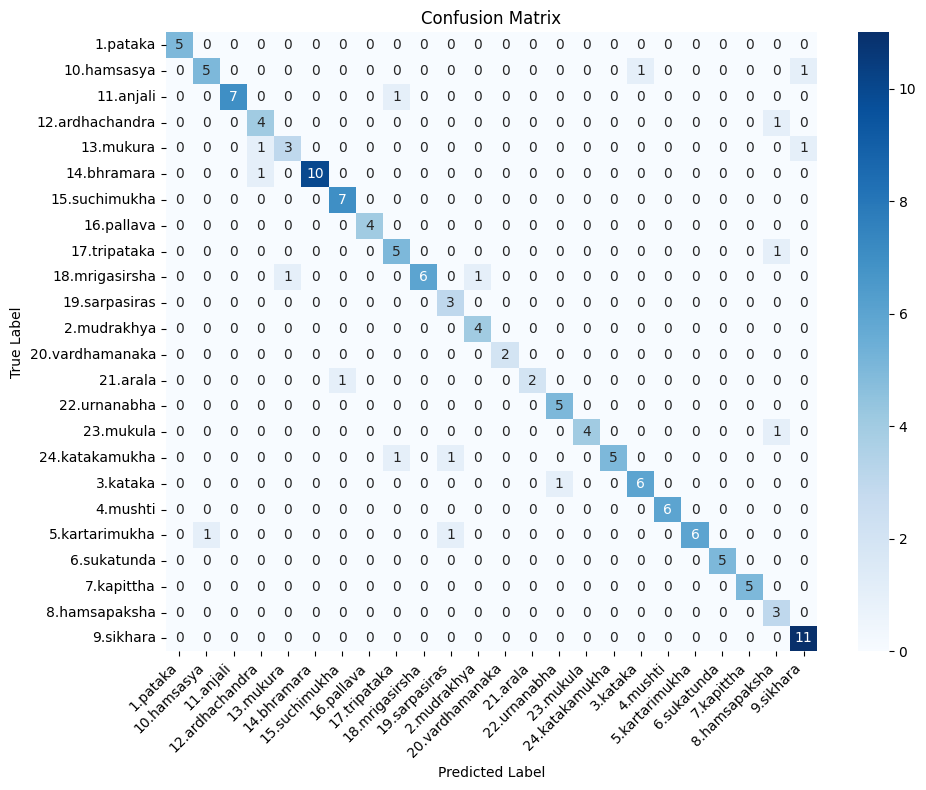

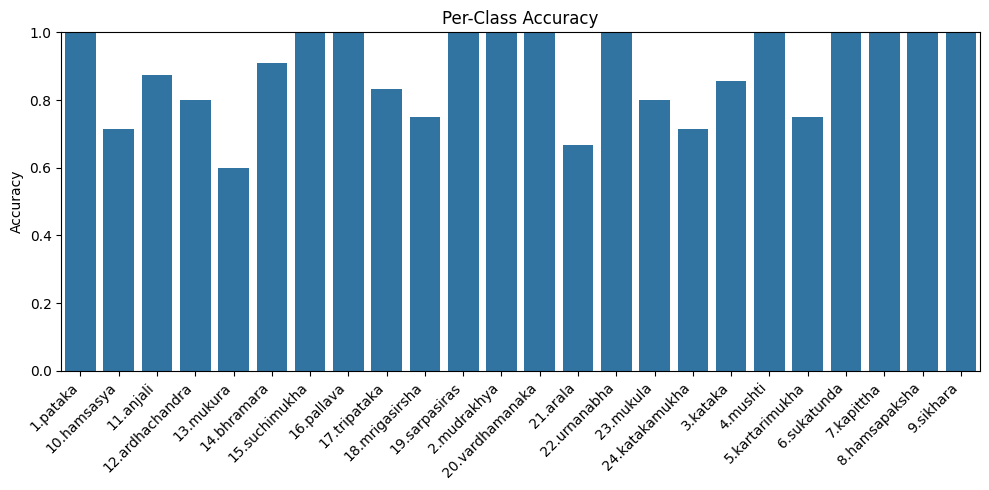

In [8]:
# =============================================================================
# CELL 4: EVALUATION ON TEST DATA (ENHANCED WITH VISUALIZATIONS)
# =============================================================================
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

print("\n" + "="*80)
print("### EXECUTING CELL 4: FINAL EVALUATION ON TEST DATA ###".center(80))
print("="*80)

# 1. Regenerate test loader
_, _, test_loader_final, num_classes_final, class_names_final = get_data_loaders(
    config['base_dir'], config['img_size'], config['stage3_batch_size'], config['num_workers']
)

# 2. Define evaluation function
def evaluate_on_test(model, loader, device, class_names):
    """Evaluates model on test set and plots detailed metrics."""
    model.eval()
    all_preds, all_labels, all_features = [], [], []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Evaluating on Test Set"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Store features (before final layer) if model returns them
            if hasattr(model, 'extract_features'):
                feats = model.extract_features(inputs).cpu().numpy()
                all_features.append(feats)
            
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.numpy())

    # Flatten feature arrays if collected
    if len(all_features) > 0:
        all_features = np.concatenate(all_features, axis=0)
    else:
        all_features = np.zeros((len(all_labels), 1))

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    
    print("\n" + "="*80)
    print("🏆 FINAL MODEL PERFORMANCE ON TEST SET 🏆".center(80))
    print("="*80)
    print(f"\nOverall Test Accuracy: {accuracy:.4f} ({accuracy:.2%})\n")
    print("Classification Report:")
    print(report)
    print("="*80)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Per-Class Accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=class_names, y=per_class_acc)
    plt.title("Per-Class Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Scatter Visualization using t-SNE or PCA if features exist
    if all_features.shape[1] > 1:
        print("\nGenerating 2D feature scatter visualization (t-SNE)...")
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            reduced = tsne.fit_transform(all_features)
        except Exception:
            print("t-SNE failed (possibly too large); using PCA instead.")
            pca = PCA(n_components=2)
            reduced = pca.fit_transform(all_features)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=all_labels, cmap='tab20', alpha=0.7)
        plt.title("Feature Embedding Visualization (t-SNE/PCA)")
        plt.colorbar(scatter, ticks=range(len(class_names)))
        plt.clim(-0.5, len(class_names)-0.5)
        plt.show()

# 3. Load model and evaluate
final_model = TransformersClassifier(config['model_name'], num_classes_final).to(device)
print(f"Loading best fine-tuned model from: {config['stage3_save_path']}")
final_checkpoint = torch.load(config['stage3_save_path'], map_location=device)
final_model.load_state_dict(final_checkpoint['model_state_dict'])

evaluate_on_test(final_model, test_loader_final, device, class_names_final)
